<a href="https://colab.research.google.com/github/Butsay-Cha/Butsaya-Portfolio/blob/main/GRU_BMW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import pandas as pd
import numpy as np
import math
import datetime as dt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score
from sklearn.preprocessing import MinMaxScaler

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.layers import LSTM, GRU

from itertools import cycle
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots


# Download Dataset

In [ ]:
df = pd.read_csv('/content/BMW.DE.csv')
df = df.rename(columns={'Date': 'date', 'Open':'open', 'High':'high', 'Low':'low', 'Close':'close', 'Adj Close':'adj_close', 'Volume':'volume'})
df.head()

,date,open,high,low,close,adj_close,volume
0,2022-05-30,80.250000,80.250000,80.250000,80.250000,73.957329,0.0
1,2022-05-31,81.320000,81.639999,80.169998,80.629997,74.307533,1807592.0
2,2022-06-01,81.529999,83.180000,81.250000,82.330002,75.874237,1608890.0
3,2022-06-02,82.330002,82.330002,82.330002,82.330002,75.874237,0.0
4,2022-06-03,82.330002,82.330002,82.330002,82.330002,75.874237,0.0


<a name="na"></a>

# Checking missing value

In [ ]:
print("Null values :", df.isnull().values.sum())
print("NA values :", df.isna().values.any())

Null values : 12
NA values : True


In [ ]:
df = df.dropna()

In [ ]:
print("Null values :", df.isnull().values.sum())
print("NA values :", df.isna().values.any())

Null values : 0
NA values : False


<a name="predate"></a>

# Convert Date to datetime format

In [ ]:
df['date'] = pd.to_datetime(df.date)
df.head()

,date,open,high,low,close,adj_close,volume
0,2022-05-30,80.250000,80.250000,80.250000,80.250000,73.957329,0.0
1,2022-05-31,81.320000,81.639999,80.169998,80.629997,74.307533,1807592.0
2,2022-06-01,81.529999,83.180000,81.250000,82.330002,75.874237,1608890.0
3,2022-06-02,82.330002,82.330002,82.330002,82.330002,75.874237,0.0
4,2022-06-03,82.330002,82.330002,82.330002,82.330002,75.874237,0.0


<a name="sc"></a>

# Stock Close Price Forecasting

<a name="df"></a>

### Make separate dataframe of close price

In [ ]:
closedf = df[['date', 'close']]
closedf.shape

(254, 2)

<a name="year"></a>

# Consider only last 1 year data for prediction

In [ ]:
closedf = closedf[closedf['date'] > '2022-05-30']
close_stock = closedf.copy()
closedf.shape[0]

253

In [ ]:
fig = px.line(closedf, x=closedf.date, y=closedf.close,labels={'date':'Date','close':'Close Stock'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Considered period to predict Stock close price', plot_bgcolor='white', font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="norm"></a>

### Normalizing close price

In [ ]:
del closedf['date']
scaler = MinMaxScaler(feature_range = (0,1))
closedf = scaler.fit_transform(np.array(closedf).reshape(-1,1))
closedf.shape

(253, 1)

<a name="split"></a>

### Train & Test split

In [ ]:
training_size=int(len(closedf)*0.60)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data : ", train_data.shape)
print("test_data : ", test_data.shape)

train_data :  (151, 1)
test_data :  (102, 1)


<a name="trans"></a>

### Transform Close price base on Time-series-analysis forecasting requirement

In [ ]:
#convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [ ]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train :", X_train.shape)
print("y_train :", y_train.shape)
print("X_test :", X_test.shape)
print("y_test :", y_test.shape)

X_train : (135, 15)
y_train : (135,)
X_test : (86, 15)
y_test : (86,)


In [ ]:
#reshape input to be [samples, time steps, features]
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train :", X_train.shape)
print("X_test :", X_test.shape)

X_train : (135, 15, 1)
X_test : (86, 15, 1)


<a name="gru"></a>

# Model building

In [ ]:
tf.keras.backend.clear_session()
model=Sequential()
model.add(GRU(32,return_sequences=True,input_shape=(time_step,1)))
model.add(GRU(32,return_sequences=True))
model.add(GRU(32))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 15, 32)            3360      
                                                                 
 gru_1 (GRU)                 (None, 15, 32)            6336      
                                                                 
 gru_2 (GRU)                 (None, 32)                6336      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 16,065
Trainable params: 16,065
Non-trainable params: 0
_________________________________________________________________


In [ ]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=32,verbose=1)

Epoch 1/100
5/5 [==============================] - 8s 416ms/step - loss: 0.0348 - val_loss: 0.1530
Epoch 2/100
5/5 [==============================] - 0s 57ms/step - loss: 0.0076 - val_loss: 0.0310
Epoch 3/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0091 - val_loss: 0.0713
Epoch 4/100
5/5 [==============================] - 0s 49ms/step - loss: 0.0049 - val_loss: 0.1128
Epoch 5/100
5/5 [==============================] - 0s 53ms/step - loss: 0.0059 - val_loss: 0.0836
Epoch 6/100
5/5 [==============================] - 0s 61ms/step - loss: 0.0040 - val_loss: 0.0345
Epoch 7/100
5/5 [==============================] - 0s 40ms/step - loss: 0.0037 - val_loss: 0.0214
Epoch 8/100
5/5 [==============================] - 0s 32ms/step - loss: 0.0031 - val_loss: 0.0268
Epoch 9/100
5/5 [==============================] - 0s 34ms/step - loss: 0.0027 - val_loss: 0.0149
Epoch 10/100
5/5 [==============================] - 0s 33ms/step - loss: 0.0023 - val_loss: 0.0048
Epoch 11/100
5/5 [

<a name="loss"></a>

### Loss chart

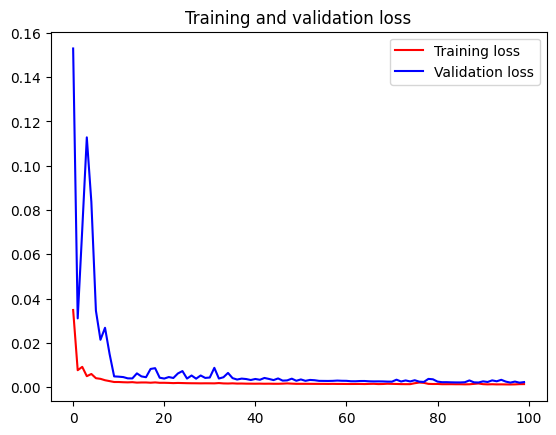

<Figure size 640x480 with 0 Axes>

In [ ]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [ ]:
#prediction
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

3/3 [==============================] - 0s 9ms/step


((135, 1), (86, 1))

<a name="eval"></a>

# Model evaluation

In [ ]:
#transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

<a name="mse"></a>

### Evaluation metrices - RMSE, MSE and MAE

In [ ]:
print("Train data RMSE :", '{:.4f}'.format(math.sqrt(mean_squared_error(original_ytrain, train_predict))))
print("Train data MSE :", '{:.4f}'.format(mean_squared_error(original_ytrain, train_predict)))
print("Train data MAE :", '{:.4f}'.format(mean_absolute_error(original_ytrain, train_predict)))
print("------------------------------------")
print("Test data RMSE :", '{:.4f}'.format(math.sqrt(mean_squared_error(original_ytest, test_predict))))
print("Test data MSE :", '{:.4f}'.format(mean_squared_error(original_ytest, test_predict)))
print("Test data MAE :", '{:.4f}'.format(mean_absolute_error(original_ytest, test_predict)))

Train data RMSE : 1.4111
Train data MSE : 1.9911
Train data MAE : 1.1013
------------------------------------
Test data RMSE : 1.8777
Test data MSE : 3.5259
Test data MAE : 1.3336


<a name="r2"></a>

### R<sup>2</sup> score

In [ ]:
print("Train data R2 score :", '{:.4f}'.format(r2_score(original_ytrain, train_predict)))
print("Test data R2 score :", '{:.4f}'.format(r2_score(original_ytest, test_predict)))

Train data R2 score : 0.8972
Test data R2 score : 0.7781


<a name="cp"></a>

# Comparison of original close price and predicted close price

In [ ]:
# shift train predictions for plotting
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original close price','Train predicted close price','Test predicted close price'])


plotdf = pd.DataFrame({'date': close_stock['date'],
                       'original_close': close_stock['close'],
                      'train_predicted_close': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_close': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_close'],plotdf['train_predicted_close'],
                                          plotdf['test_predicted_close']],
              labels={'value':'Stock price','date': 'Date'})
fig.update_layout(title_text='Comparison of original close price and predicted close price',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Close Price')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (253, 1)
Test predicted data:  (253, 1)


<a name="days"></a>

# Predicting next 30 days

In [ ]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 30
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  30


<a name="pdays"></a>

### Plotting last 15 days of dataset and next predicted 30 days

In [ ]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39
 40 41 42 43 44 45]


In [ ]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days close price','Predicted next 30 days close price'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 30 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Close Price')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

<a name="pwhole"></a>

### Plotting entire Closing Stock Price with next 30 days period of prediction

In [ ]:
lstmdf=closedf.tolist()
lstmdf.extend((np.array(lst_output).reshape(-1,1)).tolist())
lstmdf=scaler.inverse_transform(lstmdf).reshape(1,-1).tolist()[0]

names = cycle(['Close price'])

fig = px.line(lstmdf,labels={'value': 'Stock price','index': 'Timestamp'})
fig.update_layout(title_text='Plotting whole closing stock price with prediction',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Stock')

fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()